In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False


In [ ]:
# 5 pollutants
TARGET_COLS = ["CO(GT)", "NMHC(GT)", "C6H6(GT)", "NOx(GT)", "NO2(GT)"]

def make_feature_frame(df: pd.DataFrame,
                       target_cols=TARGET_COLS,
                       lags=(1, 6, 24),
                       ma_windows=(6, 12)) -> pd.DataFrame:
    """
    Input: preprocessed df (index = Datetime)
    Output: DataFrame with time features + lag & MA features for each pollutant
    """
    df_feat = df.copy()

    # Time features
    df_feat["hour"] = df_feat.index.hour
    df_feat["weekday"] = df_feat.index.weekday
    df_feat["month"] = df_feat.index.month

    # Generate lag & MA features for each pollutant
    for tgt in target_cols:
        for lag in lags:
            df_feat[f"{tgt}_lag_{lag}"] = df_feat[tgt].shift(lag)
        for w in ma_windows:
            df_feat[f"{tgt}_ma_{w}"] = df_feat[tgt].rolling(w, min_periods=1).mean()

    # Remove NaN caused by feature generation (first few rows)
    df_feat = df_feat.dropna()

    return df_feat

df = pd.read_csv(
    "clean_air_quality.csv",
    parse_dates=["Datetime"],
    index_col="Datetime"
)
df = df.drop(columns=["is_weekend"])
df_feat_all = make_feature_frame(df)
print("Feature frame shape:", df_feat_all.shape)
print(df_feat_all.head())

Feature frame shape: (9333, 36)
                     CO(GT)  NMHC(GT)  C6H6(GT)  NOx(GT)  NO2(GT)     T    RH  \
Datetime                                                                        
2004-03-11 18:00:00     4.8     307.0      20.8    281.0    151.0  10.3  64.2   
2004-03-11 19:00:00     6.9     461.0      27.4    383.0    172.0   9.7  69.3   
2004-03-11 20:00:00     6.1     401.0      24.0    351.0    165.0   9.6  67.8   
2004-03-11 21:00:00     3.9     197.0      12.8    240.0    136.0   9.1  64.0   
2004-03-11 22:00:00     1.5      61.0       4.7     94.0     85.0   8.2  63.4   

                         AH  hour  weekday  ...  NOx(GT)_lag_1  NOx(GT)_lag_6  \
Datetime                                    ...                                 
2004-03-11 18:00:00  0.8065    18        3  ...          243.0          104.0   
2004-03-11 19:00:00  0.8319    19        3  ...          281.0          146.0   
2004-03-11 20:00:00  0.8133    20        3  ...          383.0          207.

In [ ]:
def year_split_2004_2005(X: np.ndarray, y: np.ndarray, index: pd.DatetimeIndex):
    """
    Split by year:
      - train: year 2004
      - test : year 2005
    """
    index = pd.DatetimeIndex(index)
    mask_train = index.year == 2004
    mask_test  = index.year == 2005

    X_train, X_test = X[mask_train], X[mask_test]
    y_train, y_test = y[mask_train], y[mask_test]
    idx_train, idx_test = index[mask_train], index[mask_test]

    return X_train, X_test, y_train, y_test, idx_train, idx_test

In [26]:
def build_single_step_reg_dataset(df_feat: pd.DataFrame, target_col: str):
    """
    Use all other columns in df_feat to predict target_col(t).
    """
    feature_cols = [c for c in df_feat.columns if c != target_col]
    X = df_feat[feature_cols].values
    y = df_feat[target_col].values
    idx = df_feat.index
    return X, y, feature_cols, idx

results_single_step = []

for tgt in TARGET_COLS:
    X, y, feat_cols, idx = build_single_step_reg_dataset(df_feat_all, tgt)
    X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(X, y, idx)

    if len(X_tr) == 0 or len(X_te) == 0:
        continue

    # Standardization
    scaler = StandardScaler()
    X_tr_s = scaler.fit_transform(X_tr)
    X_te_s = scaler.transform(X_te)

    # 1) Linear Regression
    lr = LinearRegression()
    lr.fit(X_tr_s, y_tr)
    pred_lr = lr.predict(X_te_s)
    rmse_lr = mean_squared_error(y_te, pred_lr) ** 0.5

    # 2) Random Forest
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=16,
        max_features = 0.7,
        min_samples_split = 4,
        min_samples_leaf = 1,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr_s, y_tr)
    pred_rf = rf.predict(X_te_s)
    rmse_rf = mean_squared_error(y_te, pred_rf) ** 0.5

    # 3) XGBoost
    if HAS_XGB:
        xgb = XGBRegressor(
            n_estimators=900,
            max_depth=6,
            learning_rate=0.03,
            subsample=0.6,
            colsample_bytree=0.9,
            reg_alpha=0.1,
            reg_lambda=1.0,
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1
        )
        xgb.fit(X_tr_s, y_tr)
        pred_xgb = xgb.predict(X_te_s)
        rmse_xgb = mean_squared_error(y_te, pred_xgb) ** 0.5
    else:
        rmse_xgb = np.nan

    results_single_step.append((tgt, rmse_lr, rmse_rf, rmse_xgb))

print("===== Single-step regression: 2004 -> 2005 (five pollutants) =====")
print("Target   |  LR_RMSE |  RF_RMSE | XGB_RMSE")
for tgt, r_lr, r_rf, r_xgb in results_single_step:
    print(f"{tgt:8s} | {r_lr:8.4f} | {r_rf:8.4f} | {r_xgb:8.4f}")

# Convert to DataFrame for easy export to report
df_single_step = pd.DataFrame(
    results_single_step,
    columns=["target", "rmse_lr", "rmse_rf", "rmse_xgb"]
)
df_single_step

===== Single-step regression: 2004 -> 2005 (five pollutants) =====
Target   |  LR_RMSE |  RF_RMSE | XGB_RMSE
CO(GT)   |   0.2873 |   0.4073 |   0.3865
NMHC(GT) |  15.5369 |  12.7024 |  11.7106
C6H6(GT) |   1.7183 |   1.9706 |   1.8044
NOx(GT)  |  43.5751 |  63.7511 |  50.6041
NO2(GT)  |  14.2910 |  20.8228 |  16.9582


,target,rmse_lr,rmse_rf,rmse_xgb
0,CO(GT),0.287264,0.407272,0.386454
1,NMHC(GT),15.536936,12.702408,11.710582
2,C6H6(GT),1.718306,1.970634,1.804421
3,NOx(GT),43.575146,63.751143,50.604119
4,NO2(GT),14.290967,20.822830,16.958208


In [27]:
def build_multistep_regression(df_feat: pd.DataFrame,
                               target_col: str,
                               horizon: int):
    """
    Use current features X(t) to predict target_col(t+h).
    Also returns naive baseline: y_naive(t) = target_col(t).
    """
    df_tmp = df_feat.copy()
    future_col = f"{target_col}_future_{horizon}"
    df_tmp[future_col] = df_tmp[target_col].shift(-horizon)
    df_tmp = df_tmp.dropna()

    feature_cols = [c for c in df_tmp.columns if c not in [target_col, future_col]]
    X = df_tmp[feature_cols].values
    y = df_tmp[future_col].values        # True future value
    y_naive = df_tmp[target_col].values  # Naive: current value
    idx = df_tmp.index
    return X, y, y_naive, feature_cols, idx

HORIZONS = [1, 6, 12, 24]
results_multistep = []

for tgt in TARGET_COLS:
    for h in HORIZONS:
        X_h, y_h, y_naive_h, feat_h, idx_h = build_multistep_regression(
            df_feat_all, tgt, h
        )

        X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(
            X_h, y_h, idx_h
        )
        _,   _,  y_naive_tr, y_naive_te, _, _ = year_split_2004_2005(
            X_h, y_naive_h, idx_h
        )

        if len(X_tr) == 0 or len(X_te) == 0:
            continue

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_te_s = scaler.transform(X_te)

        # 0) Naive baseline
        rmse_naive = mean_squared_error(y_te, y_naive_te) ** 0.5

        # 1) Linear Regression
        lr = LinearRegression()
        lr.fit(X_tr_s, y_tr)
        pred_lr = lr.predict(X_te_s)
        rmse_lr = mean_squared_error(y_te, pred_lr) ** 0.5

        # 2) Random Forest
        rf = RandomForestRegressor(
            n_estimators=600,
            max_depth=16,
            max_features = 0.7,
            min_samples_split = 4,
            min_samples_leaf = 1,
            random_state=42,
            n_jobs=-1
        )
        rf.fit(X_tr_s, y_tr)
        pred_rf = rf.predict(X_te_s)
        rmse_rf = mean_squared_error(y_te, pred_rf) ** 0.5

        # 3) XGBoost
        if HAS_XGB:
            xgb = XGBRegressor(
                n_estimators=900,
                max_depth=6,
                learning_rate=0.03,
                subsample=0.6,
                colsample_bytree=0.9,
                reg_alpha=0.1,
                reg_lambda=1.0,
                objective='reg:squarederror',
                random_state=42,
                n_jobs=-1
            )
            xgb.fit(X_tr_s, y_tr)
            pred_xgb = xgb.predict(X_te_s)
            rmse_xgb = mean_squared_error(y_te, pred_xgb) ** 0.5
        else:
            rmse_xgb = np.nan

        results_multistep.append(
            (tgt, h, rmse_naive, rmse_lr, rmse_rf, rmse_xgb)
        )

print("===== Multi-step regression RMSE (2004 -> 2005, multiple pollutants + naive baseline) =====")
print("Target   | horizon | Naive   |  LR     |  RF     |  XGB")
for tgt, h, r_naive, r_lr, r_rf, r_xgb in results_multistep:
    print(f"{tgt:8s} | {h:7d} | {r_naive:7.4f} | {r_lr:7.4f} | {r_rf:7.4f} | {r_xgb:7.4f}")

df_multi = pd.DataFrame(
    results_multistep,
    columns=["target", "horizon", "rmse_naive", "rmse_lr", "rmse_rf", "rmse_xgb"]
)
df_multi

===== Multi-step regression RMSE (2004 -> 2005, multiple pollutants + naive baseline) =====
Target   | horizon | Naive   |  LR     |  RF     |  XGB
CO(GT)   |       1 |  0.7736 |  0.7266 |  0.7534 |  0.8112
CO(GT)   |       6 |  1.7720 |  1.3330 |  1.1107 |  1.0781
CO(GT)   |      12 |  1.7692 |  1.2187 |  1.2754 |  1.1807
CO(GT)   |      24 |  1.2523 |  1.2877 |  1.3063 |  1.2151
NMHC(GT) |       1 |  0.0000 | 16.1371 | 16.7614 | 16.1981
NMHC(GT) |       6 |  0.0000 | 15.2099 | 92.5170 | 78.6905
NMHC(GT) |      12 |  0.0000 | 14.3915 |  9.4173 | 52.1259
NMHC(GT) |      24 |  0.0000 | 20.3932 | 41.0441 | 13.2898
C6H6(GT) |       1 |  3.5974 |  4.1296 |  3.6575 |  3.6817
C6H6(GT) |       6 |  8.1124 |  6.4843 |  5.9233 |  5.6863
C6H6(GT) |      12 |  8.3804 |  6.3128 |  6.0664 |  6.2760
C6H6(GT) |      24 |  5.8819 |  6.4598 |  6.6244 |  6.8303
NOx(GT)  |       1 | 108.7930 | 108.9284 | 126.2488 | 110.4705
NOx(GT)  |       6 | 274.1237 | 207.4124 | 199.0353 | 194.0683
NOx(GT)  |      12

,target,horizon,rmse_naive,rmse_lr,rmse_rf,rmse_xgb
0,CO(GT),1,0.773599,0.726597,0.753368,0.811243
1,CO(GT),6,1.772038,1.333007,1.110744,1.078071
2,CO(GT),12,1.769159,1.218713,1.275407,1.180713
3,CO(GT),24,1.252310,1.287714,1.306304,1.215063
4,NMHC(GT),1,0.000000,16.137116,16.761357,16.198134
5,NMHC(GT),6,0.000000,15.209945,92.517018,78.690464
6,NMHC(GT),12,0.000000,14.391517,9.417348,52.125934
7,NMHC(GT),24,0.000000,20.393181,41.044135,13.289802
8,C6H6(GT),1,3.597407,4.129648,3.657507,3.681748
9,C6H6(GT),6,8.112357,6.484250,5.923281,5.686308


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Custom RMSE scorer (larger is better, so take negative)
rmse_scorer = make_scorer(
    lambda yt, yp: -mean_squared_error(yt, yp) ** 0.5
)

# Select a typical task: CO(GT), horizon = 6
TUNE_TARGET = "CO(GT)"
TUNE_H = 6

X_h, y_h, y_naive_h, feat_h, idx_h = build_multistep_regression(
    df_feat_all, TUNE_TARGET, TUNE_H
)

X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(
    X_h, y_h, idx_h
)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)


In [ ]:
# find Random Forest Optimal Parameters
from sklearn.ensemble import RandomForestRegressor

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_param_dist = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [8, 12, 16, 20, None],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", 0.7]
}

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=20,        # Randomly sample 20 parameter sets
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_search.fit(X_tr_s, y_tr)

print("Best RF params:", rf_search.best_params_)
print("Best CV RMSE:", -rf_search.best_score_)

best_rf = rf_search.best_estimator_
rf_tune_pred = best_rf.predict(X_te_s)
rf_tune_rmse = mean_squared_error(y_te, rf_tune_pred) ** 0.5
print("RF tuned test RMSE:", rf_tune_rmse)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/wxl/Desktop/python/py/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RF params: {'n_estimators': 600, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 16}
Best CV RMSE: 1.0600815259876446
RF tuned test RMSE: 1.1107441069239756


In [ ]:
# find XGBoost Optimal Parameters
if HAS_XGB:
    xgb_base = XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"  # Faster on CPU
    )

    xgb_param_dist = {
        "n_estimators": [300, 600, 900, 1200],
        "max_depth": [3, 4, 5, 6, 8],
        "learning_rate": [0.02, 0.03, 0.05, 0.1],
        "subsample": [0.6, 0.7, 0.8, 0.9],
        "colsample_bytree": [0.6, 0.7, 0.8, 0.9],
        "reg_alpha": [0.0, 0.01, 0.1, 1.0],
        "reg_lambda": [1.0, 2.0, 5.0, 10.0]
    }

    xgb_search = RandomizedSearchCV(
        xgb_base,
        xgb_param_dist,
        n_iter=25,
        scoring=rmse_scorer,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    xgb_search.fit(X_tr_s, y_tr)

    print("Best XGB params:", xgb_search.best_params_)
    print("Best CV RMSE:", -xgb_search.best_score_)

    best_xgb = xgb_search.best_estimator_
    xgb_tune_pred = best_xgb.predict(X_te_s)
    xgb_tune_rmse = mean_squared_error(y_te, xgb_tune_pred) ** 0.5
    print("XGB tuned test RMSE:", xgb_tune_rmse)
else:
    print("XGBoost not available; skip tuning.")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best XGB params: {'subsample': 0.6, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.03, 'colsample_bytree': 0.9}
Best CV RMSE: 1.049773668231401
XGB tuned test RMSE: 1.078070665562315


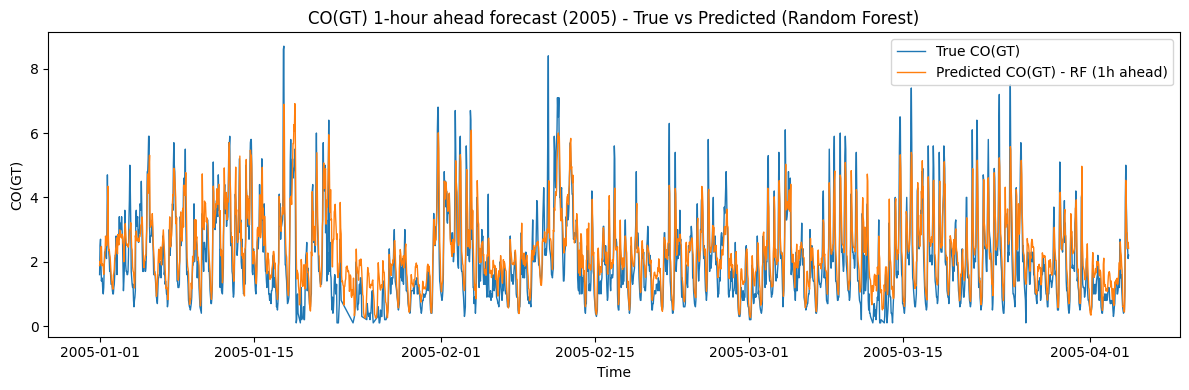

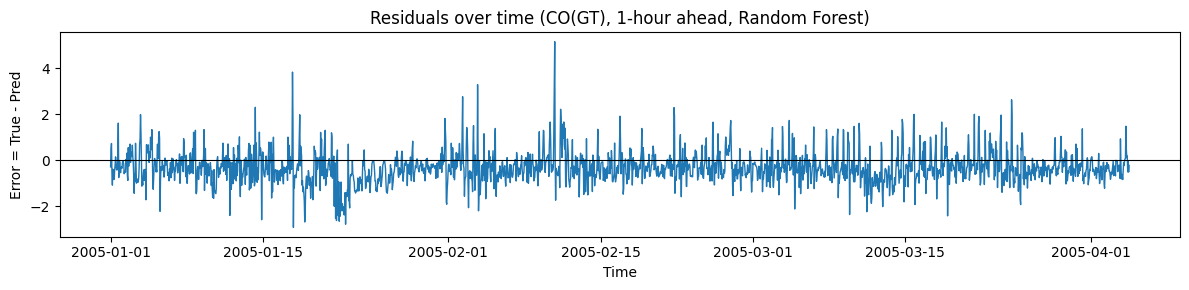

In [28]:
# Select an example: CO, horizon=1
tgt = "CO(GT)"
h = 1

X_h, y_h, y_naive_h, feat_h, idx_h = build_multistep_regression(
    df_feat_all, tgt, h
)
X_tr, X_te, y_tr, y_te, idx_tr, idx_te = year_split_2004_2005(
    X_h, y_h, idx_h
)

scaler = StandardScaler()
X_tr_s = scaler.fit_transform(X_tr)
X_te_s = scaler.transform(X_te)

rf_demo = RandomForestRegressor(
    n_estimators=600,
    max_depth=16,
    max_features = 0.7,
    min_samples_split = 4,
    min_samples_leaf = 1,
    random_state=42,
    n_jobs=-1
)
rf_demo.fit(X_tr_s, y_tr)
y_pred_demo = rf_demo.predict(X_te_s)

# (1) Prediction vs True curve
plt.figure(figsize=(12, 4))
plt.plot(idx_te, y_te, label="True CO(GT)", linewidth=1)
plt.plot(idx_te, y_pred_demo, label="Predicted CO(GT) - RF (1h ahead)", linewidth=1)
plt.title("CO(GT) 1-hour ahead forecast (2005) - True vs Predicted (Random Forest)")
plt.xlabel("Time")
plt.ylabel("CO(GT)")
plt.legend()
plt.tight_layout()
plt.show()

# (2) Residuals vs time curve
residuals = y_te - y_pred_demo
plt.figure(figsize=(12, 3))
plt.plot(idx_te, residuals, linewidth=1)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Residuals over time (CO(GT), 1-hour ahead, Random Forest)")
plt.xlabel("Time")
plt.ylabel("Error = True - Pred")
plt.tight_layout()
plt.show()


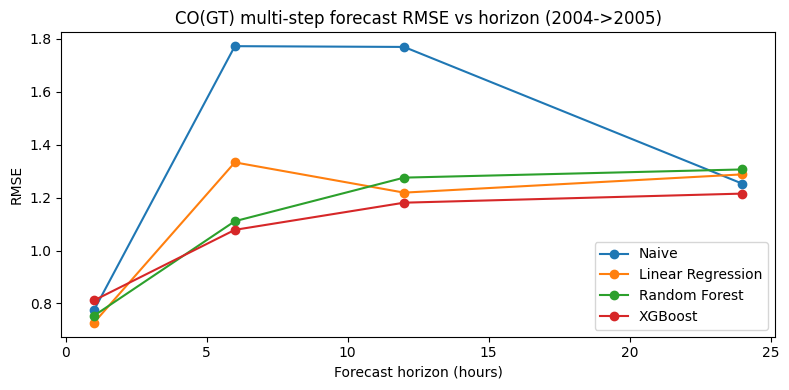

In [25]:
df_co_multi = df_multi[df_multi["target"] == "CO(GT)"].sort_values("horizon")

plt.figure(figsize=(8, 4))
plt.plot(df_co_multi["horizon"], df_co_multi["rmse_naive"], marker="o", label="Naive")
plt.plot(df_co_multi["horizon"], df_co_multi["rmse_lr"], marker="o", label="Linear Regression")
plt.plot(df_co_multi["horizon"], df_co_multi["rmse_rf"], marker="o", label="Random Forest")
if HAS_XGB:
    plt.plot(df_co_multi["horizon"], df_co_multi["rmse_xgb"], marker="o", label="XGBoost")
plt.xlabel("Forecast horizon (hours)")
plt.ylabel("RMSE")
plt.title("CO(GT) multi-step forecast RMSE vs horizon (2004->2005)")
plt.legend()
plt.tight_layout()
plt.show()